<h1>Задача «Классификация агрокультур на основе изменения показателя вегетационных индексов во временной последовательности»

<H2>Условие задачи

Перед участниками чемпионата стоит
задача
классификации
агрокультур на основе изменения показателя вегетационных индексов во
временной последовательности. Созданная за время чемпионата модель
поможет оптимизировать рабочие процессы в сфере сельского хозяйства,
обеспечить
органы
власти
актуальными
и
достоверными
сведениями,
увеличить социальный, инвестиционный и производственный потенциал
отрасли,
а
также
повысить
достоверность
и
удобство использования
информации о сельскохозяйственных объектах.

<h3>Описание входных значений</h3>

● train.csv — файл, содержащий данные о поле и временные ряды

● test.csv — файл, содержащий данные для предсказания

● sample_solution.csv — пример файла для отправки

**Пояснения к столбцам**



*   id – идентификатор объекта (поля)
*   area – площадь поля в га
*   nd mean YYYY-MM-DD – медианное значение вегетационного индекса
NDVI для данного поля на указанную дату
*   geo – координаты границ поля
*   crop – столбец для предсказания, содержит тип произрастающей
культуры по данным сельхозтоваропроизводителей

**Дополнительно расшифруем типы культур:**

0.   подсолнечник
1.   картофель
2.   пшеница озимая
3.   гречиха
4.   кукуруза
5.   пшеница яровая
6.   сахарная свекла

**Метрика**

В качестве метрики выступает Recall по столбцу crop.


In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импорт библиотек
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb


from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline


#импорт для нейронки
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras import layers


import warnings
from warnings import filterwarnings
warnings.filterwarnings('error')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
%matplotlib inline

RANDOM_STATE = 12345

In [3]:
# загрузка датасетов
try:
    df_train = pd.read_csv("/content/train_dataset_train.csv")
    df_test = pd.read_csv("/content/test_dataset_test.csv")
except:
    df_train = pd.read_csv('D:/Соревнования/Иннополис/Иннополис/train_dataset_train.csv')
    df_test = pd.read_csv('D:/Соревнования/Иннополис/Иннополис/test_dataset_test.csv')

In [4]:
# функция на первичную проверку данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.info())
    print('Первые строки датасета\n')
    display(dataset.head())
    print('Описательная статистика\n')
    display(dataset.describe())
    print('Описательная статистика столбцов object\n')
    display(dataset.describe(include=['object', 'bool']))
    print('Количество пропусков в каждом столбце\n')
    display(dataset.isna().sum())
    print('Количество уникальных значений\n')
    display(dataset.nunique())
    print('Количество дубликатов\n')
    display(dataset.duplicated().sum())

In [5]:
df_check(df_train)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3473.406211,53.871429,0.149911,0.118843,0.158939,0.166146,0.125002,0.162440,0.092302,0.108834,...,0.153016,0.168406,0.111583,0.141471,0.172343,0.121483,0.145211,0.107207,0.119274,2.953830
std,1984.993812,34.191660,0.112598,0.103192,0.136001,0.123605,0.117605,0.145027,0.095207,0.120939,...,0.185321,0.219428,0.150879,0.190674,0.228629,0.151392,0.162711,0.108508,0.155346,2.004587
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.005158,-0.000653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1772.500000,26.000000,0.047477,0.025280,0.050124,0.053859,0.027609,0.040885,0.012844,0.014682,...,0.020299,0.020892,0.012363,0.017028,0.018379,0.015292,0.022416,0.017028,0.011673,1.000000
50%,3489.500000,45.000000,0.142240,0.097346,0.129819,0.155571,0.096516,0.121307,0.069936,0.077155,...,0.086570,0.086574,0.068423,0.077626,0.085643,0.076428,0.088429,0.079537,0.070808,3.000000
75%,5191.750000,76.000000,0.245596,0.202955,0.241323,0.269131,0.192070,0.277772,0.143207,0.162079,...,0.189195,0.190436,0.149199,0.168154,0.192834,0.162134,0.198258,0.162584,0.158424,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


Описательная статистика столбцов object



,.geo
count,4830
unique,4830
top,"{""type"":""Polygon"",""coordinates"":[[[42.49107269..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
crop                  0
Length: 74, dtype: int64

Количество уникальных значений



id                    4830
area                   131
nd_mean_2021-04-16    4272
nd_mean_2021-04-19    4081
nd_mean_2021-04-22    4298
                      ... 
nd_mean_2021-08-13    3939
nd_mean_2021-08-27    4054
nd_mean_2021-05-08    4002
nd_mean_2021-05-24    3899
crop                     7
Length: 74, dtype: int64

Количество дубликатов



0

Сейчас разберу целевой столбец crop. Популярность культур и зависимость этого столбца от других данных.

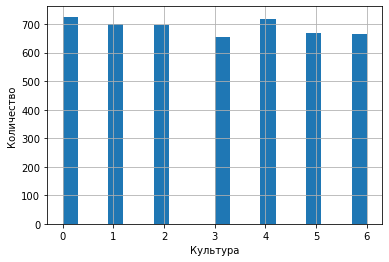

In [6]:
df_train['crop'].hist(bins=20)
plt.xlabel('Культура')
plt.ylabel('Количество')
plt.show()

In [7]:
df_train['crop'].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

Целевой признак выглядит сбалансированным

In [8]:
cols = ['id', 'nd_mean_2021-04-16', 'nd_mean_2021-04-19', 'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
         'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07', 'nd_mean_2021-05-16', 'nd_mean_2021-05-17',
         'nd_mean_2021-05-21', 'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29', 'nd_mean_2021-06-06',
         'nd_mean_2021-06-13', 'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19', 'nd_mean_2021-06-20',
          'nd_mean_2021-06-22', 'nd_mean_2021-06-25', 'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
          'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15', 'nd_mean_2021-07-17', 'nd_mean_2021-07-20',
          'nd_mean_2021-07-26', 'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-07', 
          'nd_mean_2021-08-12', 'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25', 'nd_mean_2021-04-27',
          'nd_mean_2021-04-29', 'nd_mean_2021-04-30', 'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
          'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01', 'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 
          'nd_mean_2021-05-15', 'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04', 'nd_mean_2021-08-10',
          'nd_mean_2021-08-23', 'nd_mean_2021-04-20', 'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
          'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05', 'nd_mean_2021-06-10', 'nd_mean_2021-07-05',
          'nd_mean_2021-08-13',  'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24']

In [9]:
df_train[cols].head(10).sort_index(ascending=True)

,id,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,3536,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,0.484102,...,0.425571,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498
1,3739,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,0.519456,...,0.248935,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997
2,1294,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,0.000000,...,0.127633,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614
3,2859,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,0.510271,...,0.527583,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523
4,3685,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,0.000000,...,0.000000,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539
5,6443,0.280111,0.255778,0.174677,0.327109,0.052556,0.093938,0.000000,0.084180,0.438128,...,0.596844,0.550864,0.597998,0.039885,0.773661,0.681998,0.040244,0.377847,0.030631,0.000000
6,6889,0.065092,0.095285,0.317724,0.092715,0.210422,0.000000,0.103085,0.049388,0.566210,...,0.161205,0.108805,0.079312,0.032510,0.000000,0.095017,0.138907,0.030898,0.006197,0.170735
7,5703,0.019472,0.250000,0.000000,0.254601,0.000000,0.300878,0.153703,0.122723,0.352370,...,0.233836,0.019850,0.208412,0.230455,0.000000,0.011134,0.006577,0.073889,0.132709,0.114116
8,1112,0.140723,0.151389,0.084425,0.200453,0.031948,0.066672,0.091610,0.000000,0.321452,...,0.052141,0.000000,0.160664,0.082408,0.004456,0.057482,0.225484,0.237937,0.153852,0.164892
9,776,0.259478,0.275341,0.206800,0.113008,0.101093,0.280849,0.040560,0.043373,0.231380,...,0.052068,0.000000,0.008591,0.095069,0.251147,0.025550,0.049767,0.047431,0.000000,0.214064


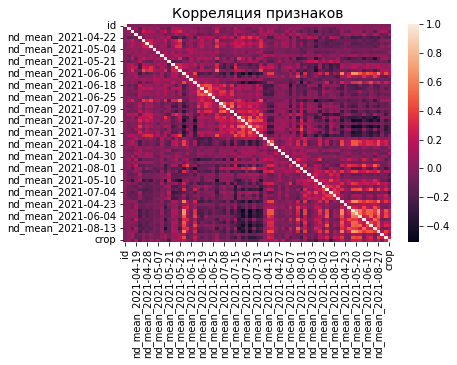

In [10]:
sns.heatmap(df_train.corr())
plt.title('Корреляция признаков', fontsize=14)

plt.show()

Явных зависимостей не выявлено. Приступлю к замене значений временных рядов у которых есть пропуски и они заменены нулями.

In [11]:
df_new_train = df_train.copy()

Пропуски заполнены нулевыми значениями, так же есть отрицательные значения, хотя диапазон nd mean от 0 до 1.

In [12]:
# все отрицательные и нулевые значения заменю на NaN
df_new_train[df_new_train[cols] <= 0] = np.nan

In [13]:
df_new_train['crop'].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

In [14]:
# все наны преобразую в среднее значение
for i in df_new_train.columns[df_new_train.isnull().any(axis=0)]:
    df_new_train[i].fillna(df_new_train[i].mean(),inplace=True)

In [15]:
# проверю что с моим датасетом
df_check(df_new_train)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   float64
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536.0,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.133690,...,0.108999,0.118854,0.137838,0.171041,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739.0,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.185044,0.140326,0.163340,...,0.134469,0.208268,0.137838,0.171041,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294.0,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.185044,0.037446,0.506516,...,0.084467,0.201038,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859.0,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.185044,0.114313,0.043604,...,0.183758,0.642226,0.132886,0.171041,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685.0,33,0.130885,0.063492,0.024416,0.185503,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3474.125492,53.871429,0.169452,0.140483,0.178529,0.185503,0.146544,0.185044,0.114313,0.133690,...,0.183758,0.201038,0.137838,0.171041,0.207430,0.148811,0.172921,0.129420,0.147792,2.953830
std,1984.364272,34.191660,0.098733,0.089868,0.124024,0.109825,0.105534,0.131759,0.083859,0.109181,...,0.172158,0.206524,0.140835,0.179367,0.214995,0.139996,0.149834,0.096913,0.143980,2.004587
min,1.000000,10.000000,0.000441,0.000222,0.000527,0.000390,0.000354,0.000267,0.000284,0.000211,...,0.000336,0.000171,0.000207,0.000405,0.000261,0.000285,0.000091,0.000126,0.000203,0.000000
25%,1774.500000,26.000000,0.089240,0.066971,0.083158,0.094366,0.065036,0.077021,0.055371,0.057481,...,0.063236,0.062865,0.055047,0.056469,0.062351,0.058238,0.062928,0.058067,0.055871,1.000000
50%,3489.500000,45.000000,0.169452,0.140483,0.171480,0.185503,0.146544,0.179421,0.114313,0.133690,...,0.146948,0.145439,0.125763,0.133139,0.148611,0.134479,0.148893,0.129420,0.134762,3.000000
75%,5191.750000,76.000000,0.245596,0.202955,0.241323,0.269131,0.192070,0.277772,0.143207,0.162079,...,0.189195,0.201038,0.149199,0.171041,0.207430,0.162134,0.198258,0.162584,0.158424,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


Описательная статистика столбцов object



,.geo
count,4830
unique,4830
top,"{""type"":""Polygon"",""coordinates"":[[[42.49107269..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
crop                  0
Length: 74, dtype: int64

Количество уникальных значений



id                    4830
area                   131
nd_mean_2021-04-16    4272
nd_mean_2021-04-19    4081
nd_mean_2021-04-22    4298
                      ... 
nd_mean_2021-08-13    3939
nd_mean_2021-08-27    4054
nd_mean_2021-05-08    4002
nd_mean_2021-05-24    3899
crop                     7
Length: 74, dtype: int64

Количество дубликатов



0

NaN заменены, пропусков нет, нулевых значений тоже. Явной зависимости целевого признака не обнаружено.

In [16]:
df_new_train['crop'].value_counts()

0    726
4    718
1    700
2    697
5    668
6    666
3    655
Name: crop, dtype: int64

Данные сбалансированы.

## Обучение модели

В качестве признаков буду использовать nd_mean по времени и площадь, а в качестве цели предсказания будет crop - засеянная культура.

In [17]:
X = df_new_train.drop(['.geo', 'crop'], axis = 1)
y = df_new_train[['crop']]

In [18]:
# разделю данные
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, 
                                                      random_state=RANDOM_STATE, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5,
                                                    random_state=RANDOM_STATE, stratify=y_valid)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2898, 72) (966, 72) (966, 72)
(2898, 1) (966, 1) (966, 1)


In [19]:
y.value_counts()

crop
0       726
4       718
1       700
2       697
5       668
6       666
3       655
dtype: int64

In [20]:
# стандартизация данных
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
X_valid_scaled = ss.transform(X_valid)
y_train_ss = np.array(y_train)
y_test_ss = np.array(y_test)

# для нейронки
y_train_nero = utils.to_categorical(y_train)
y_test_nero = utils.to_categorical(y_test)
y_valid_nero = utils.to_categorical(y_valid)

In [21]:
# обучение моделей
model_rfc = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_STATE)
model_knc = KNeighborsClassifier()
model_lr = LogisticRegression(verbose=1, n_jobs=-1, random_state=RANDOM_STATE) 
model_svc = svm.SVC(random_state=RANDOM_STATE)
model_HGBGT = HistGradientBoostingClassifier(loss='categorical_crossentropy',
                                             max_iter=2000, random_state=RANDOM_STATE)
model_LGBM = LGBMClassifier(random_state=RANDOM_STATE)
model_xgb_cl = xgb.XGBClassifier(random_state=RANDOM_STATE)


In [22]:
%%time
model_rfc.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_rfc = model_rfc.predict(X_test_scaled)

model_knc.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_knc = model_knc.predict(X_test_scaled)

model_lr.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_lr = model_lr.predict(X_test_scaled)

model_svc.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_svc = model_svc.predict(X_test_scaled)

model_HGBGT.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_HGBGT = model_HGBGT.predict(X_test_scaled)

model_LGBM.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_LGBM = model_LGBM.predict(X_test_scaled)

model_xgb_cl.fit(X_train_scaled, np.ravel(y_train_ss, order='C'))
pred_xgb_cl = model_xgb_cl.predict(X_test_scaled)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished


CPU times: total: 2min 40s
Wall time: 29.9 s


По условию задачи метрика, по которой определяется эффективность модели, - это recall, поэтому приведу эту метрику для каждой модели.

In [23]:
print(model_rfc,'\n', recall_score(y_test_ss, pred_rfc, average="macro", zero_division=0))
print(model_knc,'\n', recall_score(y_test_ss, pred_knc, average="macro", zero_division=0))
print(model_lr,'\n', recall_score(y_test_ss, pred_lr, average="macro", zero_division=0))
print(model_svc,'\n', recall_score(y_test_ss, pred_svc, average="macro", zero_division=0))
print(model_HGBGT,'\n', recall_score(y_test_ss, pred_HGBGT, average="macro", zero_division=0))
print(model_LGBM,'\n', recall_score(y_test_ss, pred_LGBM, average="macro", zero_division=0))
print(model_xgb_cl,'\n', recall_score(y_test_ss, pred_xgb_cl, average="macro", zero_division=0))

RandomForestClassifier(random_state=12345) 
 0.9508829145357914
KNeighborsClassifier() 
 0.9120313955237566
LogisticRegression(n_jobs=-1, random_state=12345, verbose=1) 
 0.9226043920874523
SVC(random_state=12345) 
 0.9481542586253806
HistGradientBoostingClassifier(loss='categorical_crossentropy', max_iter=2000,
                               random_state=12345) 
 0.9603575068016996
LGBMClassifier(random_state=12345) 
 0.961364427885995
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
 

Лучшей моделью себя показала HistGradientBoostingClassifier. (Я участвовал на Всероссийском соревновании и очень много тестировал, разные модели с разными параметрами и xgb и lgbm проигрывали в результатах, но именно сейчас показали свои лучшие результаты, но итогом я возьму model_HGBGT) Проверю на валидационной выборке

In [24]:
pred_HGBGT_valid = model_HGBGT.predict(X_valid_scaled)
print(model_HGBGT,'\n', recall_score(y_valid, pred_HGBGT_valid, average="macro", zero_division=0))

HistGradientBoostingClassifier(loss='categorical_crossentropy', max_iter=2000,
                               random_state=12345) 
 0.9691789062984828


Результат на валидационной выборке даже чуть лучше, чем ожидалось.

Заодно проверю как на валидационных данных показывают себя другие модели.

In [25]:
pred_model_LGBM_valid = model_LGBM.predict(X_valid_scaled)
print(model_LGBM,'\n', recall_score(y_valid, pred_model_LGBM_valid, average="macro", zero_division=0))

LGBMClassifier(random_state=12345) 
 0.9641367350295634


In [26]:
pred_model_xgb_cl_valid = model_xgb_cl.predict(X_valid_scaled)
print(model_xgb_cl,'\n', recall_score(y_valid, pred_model_xgb_cl_valid, average="macro", zero_division=0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...) 
 0.9592455445444197


На соревновании (итоги были подведены 20.11.2022 в 15:00 МСК) (занял 76 место из 236) и поэтому там был свой способ тестирования моделей и моя "моделька" на их тестовых данных (привате) показала recall = 0.969236.

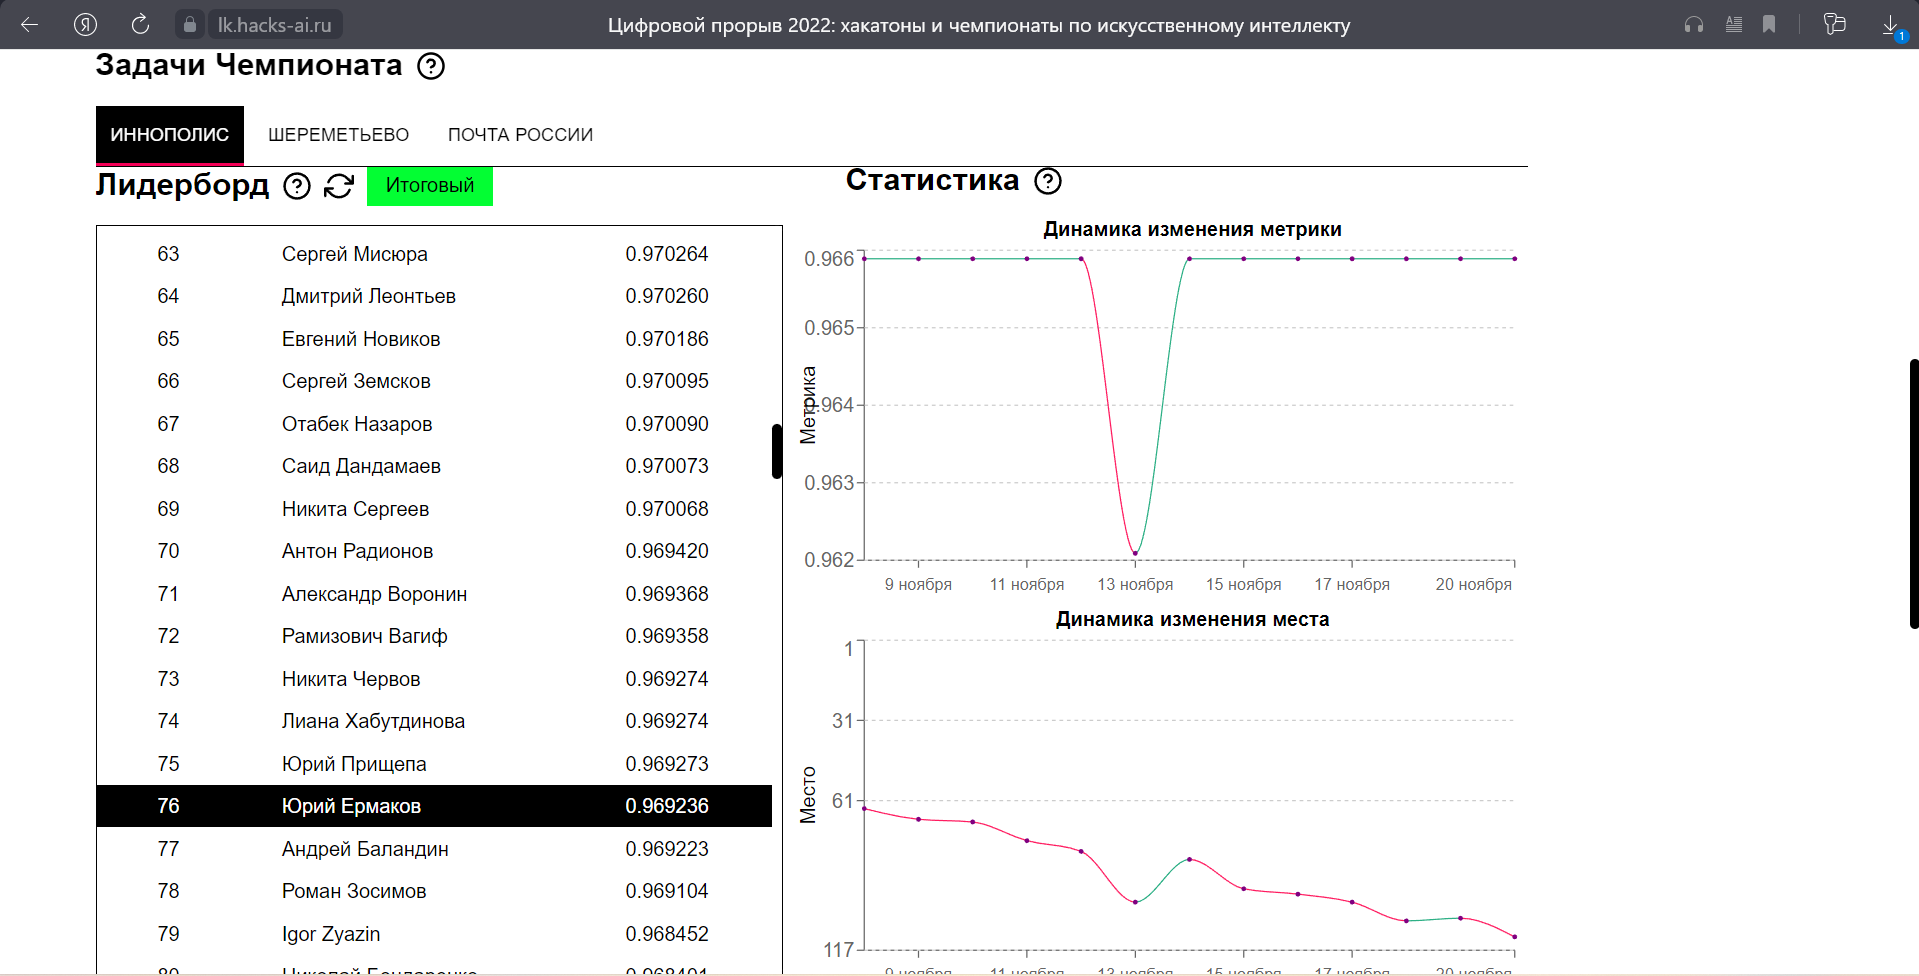

### Нейронная сеть для множественной классификации

**Спойлер**

В рамках задачи соревнования нейронки давали не очень хороший результат. Но в рамках задачи курса будет добавлена модель нейронной сети

Epoch 1/30
322/322 [==============================] - 2s 4ms/step - loss: 0.4711 - categorical_accuracy: 0.8264
Epoch 2/30
322/322 [==============================] - 1s 4ms/step - loss: 0.2208 - categorical_accuracy: 0.9213
Epoch 3/30
322/322 [==============================] - 1s 4ms/step - loss: 0.1694 - categorical_accuracy: 0.9431
Epoch 4/30
322/322 [==============================] - 1s 3ms/step - loss: 0.1625 - categorical_accuracy: 0.9444
Epoch 5/30
322/322 [==============================] - 1s 3ms/step - loss: 0.1033 - categorical_accuracy: 0.9631
Epoch 6/30
322/322 [==============================] - 1s 4ms/step - loss: 0.0749 - categorical_accuracy: 0.9703
Epoch 7/30
322/322 [==============================] - 1s 4ms/step - loss: 0.0775 - categorical_accuracy: 0.9714
Epoch 8/30
322/322 [==============================] - 1s 3ms/step - loss: 0.0708 - categorical_accuracy: 0.9790
Epoch 9/30
322/322 [==============================] - 1s 4ms/step - loss: 0.0534 - categorical_accuracy:

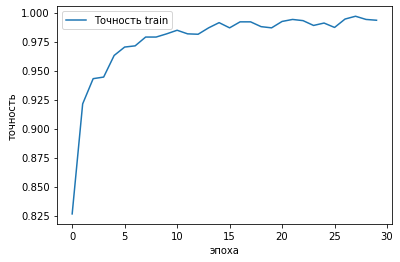

In [27]:
#модель
model_nero = Sequential()

#входные полносвязные слои
model_nero.add(Dense(720, input_dim=72, activation='relu'))
model_nero.add(Dropout(0.3))
model_nero.add(Dense(360, activation='relu'))
model_nero.add(Dropout(0.2))
model_nero.add(Dense(72, activation='relu'))
model_nero.add(Dropout(0.1))


#выходной полносвязный слой
model_nero.add(Dense(7, activation='softmax'))

model_nero.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

n = 30000

history = model_nero.fit(X_train_scaled[:n],
                    y_train_nero[:n],
                    batch_size = 9,
                    epochs = 30,
                    validation_data = (X_train_scaled[n:], y_train_nero[n:]))

plt.plot(history.history['categorical_accuracy'],
         label = 'Точность train')
plt.xlabel('эпоха')
plt.ylabel('точность')
plt.legend()
plt.show()

In [28]:
pred_nero = model_nero.predict(X_test_scaled)
pred_nero1 = np.argmax(pred_nero, axis=1)
y_test_nero = np.argmax(y_test_nero, axis=1)
cm = confusion_matrix(y_test_nero, pred_nero1)
print(cm)

31/31 [==============================] - 0s 3ms/step
[[116   0   1   0  21   0   7]
 [  0 139   0   0   1   0   0]
 [  1   0 132   0   4   0   2]
 [  0   0   0 131   0   0   0]
 [  5   0   1   0 136   0   2]
 [  1   0   0   0   0 133   0]
 [ 12   3   5   0   9   2 102]]


In [29]:
print(recall_score(y_test_nero, pred_nero1, average="macro", zero_division=0))

0.9209137831053271


Результат конечно ниже, чем у модели представленной ранее model_HGBGT поэтому создавать приложение буду по ней.

**Сохраню модель**

In [31]:
 import pickle 

 pkl_filename = "model_LGBM.pkl" 
 with open(pkl_filename, 'wb') as file:
        pickle.dump(model_LGBM, file) 
 
 # Load from file 
 with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file) 


Проверю как работает загруженная модель на предсказании.

In [32]:
pred_HGBGT_valid = model_HGBGT.predict(X_valid_scaled)
pred_HGBGT_valid

array([0, 3, 6, 0, 6, 4, 5, 5, 4, 4, 1, 0, 4, 0, 0, 1, 1, 6, 0, 2, 6, 1,
       3, 4, 3, 3, 5, 5, 6, 2, 6, 6, 4, 5, 5, 5, 4, 1, 2, 1, 2, 3, 6, 3,
       3, 4, 3, 6, 6, 1, 0, 1, 6, 4, 0, 3, 5, 3, 2, 4, 3, 0, 3, 6, 2, 6,
       1, 4, 4, 5, 0, 6, 1, 4, 3, 0, 4, 0, 5, 2, 4, 2, 5, 5, 0, 4, 2, 6,
       1, 0, 0, 6, 4, 0, 1, 4, 3, 4, 0, 2, 5, 4, 3, 4, 6, 4, 6, 6, 2, 0,
       4, 0, 1, 2, 0, 3, 1, 6, 4, 5, 3, 2, 2, 3, 0, 2, 4, 1, 3, 3, 6, 0,
       2, 1, 1, 4, 1, 0, 0, 2, 1, 0, 5, 5, 2, 0, 1, 0, 1, 6, 3, 0, 4, 0,
       3, 1, 2, 6, 1, 1, 3, 2, 5, 1, 4, 3, 6, 1, 2, 3, 4, 2, 5, 1, 4, 0,
       2, 0, 0, 4, 1, 1, 0, 0, 3, 3, 6, 2, 4, 1, 1, 5, 2, 1, 1, 0, 0, 3,
       0, 4, 5, 1, 0, 3, 4, 0, 1, 5, 0, 4, 0, 2, 6, 3, 3, 2, 6, 1, 2, 3,
       2, 3, 4, 3, 6, 0, 3, 0, 4, 4, 6, 6, 2, 6, 6, 0, 5, 6, 3, 1, 3, 5,
       3, 6, 2, 4, 1, 1, 4, 0, 1, 4, 3, 5, 4, 3, 0, 5, 3, 0, 4, 1, 3, 3,
       3, 1, 3, 5, 0, 4, 4, 3, 3, 2, 0, 3, 1, 4, 6, 2, 6, 2, 5, 4, 2, 1,
       3, 2, 4, 3, 0, 5, 0, 5, 1, 6, 4, 2, 3, 0, 0,

In [33]:
pred_HGBGT_valid_mod = pickle_model.predict(X_valid_scaled)
pred_HGBGT_valid_mod

array([0, 3, 6, 0, 6, 4, 5, 5, 4, 4, 1, 0, 4, 0, 0, 1, 1, 6, 0, 2, 6, 1,
       3, 4, 3, 3, 5, 5, 6, 2, 6, 6, 4, 5, 5, 5, 4, 1, 2, 1, 2, 3, 6, 3,
       3, 4, 3, 6, 6, 1, 0, 1, 6, 4, 0, 3, 5, 3, 2, 4, 3, 0, 3, 6, 2, 6,
       1, 4, 4, 5, 0, 6, 1, 4, 3, 0, 4, 0, 5, 2, 4, 2, 5, 5, 0, 4, 2, 6,
       1, 0, 0, 6, 4, 0, 1, 0, 3, 4, 0, 2, 5, 4, 3, 4, 6, 4, 6, 6, 2, 0,
       4, 0, 1, 2, 0, 3, 1, 6, 4, 5, 3, 2, 2, 3, 0, 2, 4, 1, 3, 3, 6, 0,
       2, 1, 4, 4, 1, 0, 0, 2, 1, 0, 5, 5, 2, 0, 1, 0, 1, 6, 3, 0, 4, 0,
       3, 1, 2, 6, 1, 1, 3, 2, 5, 1, 4, 3, 6, 1, 2, 3, 4, 2, 5, 1, 4, 0,
       2, 0, 0, 4, 1, 1, 0, 0, 3, 3, 6, 2, 4, 1, 1, 5, 2, 1, 1, 0, 0, 3,
       0, 6, 5, 1, 0, 3, 4, 0, 1, 5, 0, 4, 0, 2, 6, 3, 3, 2, 6, 1, 2, 3,
       2, 3, 4, 3, 6, 0, 3, 0, 4, 4, 6, 6, 2, 6, 6, 0, 5, 6, 3, 1, 3, 5,
       3, 6, 2, 4, 1, 1, 4, 0, 1, 4, 3, 5, 4, 3, 0, 5, 3, 0, 4, 1, 3, 3,
       3, 1, 3, 5, 0, 4, 4, 3, 3, 2, 0, 3, 1, 4, 6, 2, 6, 2, 5, 4, 2, 1,
       3, 2, 4, 3, 0, 5, 0, 5, 1, 6, 4, 2, 3, 0, 0,

Данные те же, значит загруженная моделька работает корректно и может быть использованы для работы в приложении.
В репозиториии будет добавлено приложение во flaske, единственное, что входных данных необходимо вводить аж 72 позиции, так что это надо иметь ввиду при проверке работоспособности приложения.

**ИТОГ**

В работе был проведён анализ данных, были заменены пропуски и артефакты (в виде 0 и отрицательных значений) на средние значения. Данные были стандартизированы и подготовлены. На этих данных обучал несколько моделей классификаторов. В ходе большого количества тестов лучше всех показала себя модель HistGradientBoostingClassifier. На ней же проверил валидационные данные. Так как задача была с соревнования, то там моя модель тестировалась на их собственных тестовых данных и на этих данных она показала чуть лучшее значение.

Поставленные задачи проекта были выполнены.